In [ ]:
# Imports
import scipy.io as sio
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from PIL import Image

# Drive mount
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/Shareddrives/DL_Project/"

# Data
image_path = "car_data/all_images/"
training_split = 0.8
validation_split = 0.1
# testing_split = 0.1
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")


Mounted at /content/drive
/content/drive/Shareddrives/DL_Project


# Preprocessing

In [ ]:
# Read data
df = pd.read_excel("annotations.xlsx")

# Standardization (normalizatio )
# mean_price = df['price'].mean()
# std_price = df['price'].std()
# df["price"] = (df['price']-mean_price)/std_price

# Min max scaling (normalization)
scaler = MinMaxScaler()
df['price'] = scaler.fit_transform(df['price'].to_numpy().reshape(-1, 1)).flatten()

df.head()

,image_name,x1,y1,x2,y2,label,price,name
0,00001.jpg,39,116,569,375,13,0.023722,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,2,0.017396,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,90,0.010543,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,133,0.012045,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,105,0.024776,Ford F-450 Super Duty Crew Cab 2012


### Visualization of a car

## Split

In [ ]:
# Split data
train_df, temp_df = train_test_split(df, train_size=training_split, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=validation_split/(1-training_split), stratify=temp_df['label'], random_state=42)

print(validation_split/(1-training_split))

0.5000000000000001


## Transformation

In [ ]:
# transform for Resnet
train_tf = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tf = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Resnet50

In [ ]:
# Weight initialization function
import torchvision.models as models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Resnet where we adapt last layer
class MyResNet50(nn.Module):
  def __init__(self, num_classes= 196, unfreeze_flag= True):
    super().__init__()
    resnet50_model = models.resnet50(pretrained=True)
    self.resnet50_model = resnet50_model
    if not unfreeze_flag:
      print('Freezing layers')
    for param in self.resnet50_model.parameters():
      param.require_grad = unfreeze_flag

    self.resnet50_model.fc = nn.Linear(2048, 1)
    self.resnet50_model.fc.apply(weights_init)

  def forward(self,x):
    out = self.resnet50_model(x)

    return out

In [ ]:
# Metric functions
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return torch.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
# Training
from tqdm import tqdm  # for nice progress bars

def train_model(model, train_loader,val_loader, loss_fn, optimizer, scheduler, epochs=10):
    model.to(device)
    epoch_stats = []
    previous_lr = get_lr(optimizer)
    print("Initial Learning Rate: ", previous_lr)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss, train_total = 0, 0

        for images, prices,_ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch'):
            images, prices = images.to(device), prices.to(device)

            optimizer.zero_grad()  # Zero the gradients on each batch
            outputs = model(images)  # Generate predictions

            loss = loss_fn(outputs.squeeze(), prices)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the weights

            train_loss += loss.item() * images.size(0)
            # _, predicted = torch.max(outputs, 1)
            train_total += prices.size(0)
            # train_correct += (predicted == labels).sum().item()
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_mae, total_mse, total_count = 0, 0, 0
            val_loss, val_total = 0, 0

            for images, prices,_ in val_loader:
                images, prices = images.to(device), prices.to(device)

                outputs = model(images)
                loss = loss_fn(outputs.squeeze(), prices)

                val_loss += loss.item() * images.size(0)
                val_total += prices.size(0)
                total_mae += mean_absolute_error(prices, outputs.squeeze()) * prices.size(0)
                total_mse += mean_squared_error(prices, outputs.squeeze()) * prices.size(0)
                total_count += prices.size(0)
            avg_mae = total_mae / total_count
            avg_mse = total_mse / total_count
            avg_rmse = torch.sqrt(avg_mse)
            print(f'Epoch {epoch+1}, MAE: {avg_mae}, RMSE: {avg_rmse}')

        print(f'epoch  {epoch + 1} train_loss : {train_loss / train_total} val_loss: {val_loss / val_total}')

        # val_acc =  val_correct / val_total
        # Collect statistics for the current epoch
        epoch_stats.append({
            'epoch': epoch + 1,
            'train_loss': train_loss / train_total,
            # 'train_accuracy': train_correct / train_total * 100,
            'val_loss': val_loss / val_total,
            'MAE' : avg_mae,
            'RMSE': avg_rmse,
            # 'val_accuracy': val_acc * 100
        })

        # re-set the model to train mode after validating
        model.train()

        # # Print statistics
        # print(f'Epoch {epoch+1}:')
        # print(f'Train Loss: {train_loss / train_total:.4f}, Train Acc: {train_correct / train_total * 100:.2f}%')
        # print(f'Val Loss: {val_loss / val_total:.4f}, Val Acc: {val_correct / val_total * 100:.2f}%')

        # current_loss = val_loss / val_total
        # if not isinstance(current_loss, torch.Tensor):
        #   current_loss = torch.tensor(current_loss)

        # if not torch.isnan(current_loss):
        #     scheduler.step(current_loss)
        #     previous_valid_metric = current_loss  # Track the last valid metric
        # else:
        #     scheduler.step(previous_valid_metric)  # Use the last valid loss if current is NaN
        #     print("Warning: NaN detected in loss; using last valid metric for LR scheduler.")

        scheduler.step(val_loss)
        # scheduler.step()
        current_lr = get_lr(optimizer)

        if current_lr != previous_lr:
          print(f"Learning Rate changed at epoch {epoch + 1}: {current_lr}")
          previous_lr = current_lr

    return epoch_stats

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [ ]:
# Evaluation
from torch import no_grad

def evaluate_model(model, test_loader):
  model.to(device)
  model.eval()

  y_true = []
  y_pred = []

  with no_grad():
    for images, prices,_ in tqdm(test_loader):
      images, prices = images.to(device), prices.cpu().numpy()
      outputs = model(images)
      pred = outputs.cpu().numpy()
      pred_norm = scaler.inverse_transform(pred).flatten()
      prices_norm = scaler.inverse_transform(prices.reshape(-1, 1)).flatten()

      y_true.extend(prices_norm)
      y_pred.extend(pred_norm)

  y_pred = torch.tensor(y_pred).to(device)
  y_true = torch.tensor(y_true).to(device)

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  rs = r2_score(y_true, y_pred)

  return mae, mse, rmse, rs, y_pred, y_true

In [ ]:
# Load dataset
from torch import tensor
class CarDataset(Dataset):
  def __init__(self, df, transform = None,for_training = True):
    self.dataframe = df
    self.transform = transform
    self.for_training = for_training

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    row = self.dataframe.iloc[idx]
    img_name = image_path + row["image_name"]
    image = Image.open(img_name).convert('RGB')

    if self.for_training:
      crop_box = (row["x1"],row["y1"],row["x2"],row["y2"])
      image = image.crop(crop_box)

    if self.transform:
      image = self.transform(image)

    label = self.dataframe.iloc[idx]["label"]
    price = self.dataframe.iloc[idx]["price"]

    label = tensor(label,dtype= torch.long)
    price = tensor(price,dtype= torch.float)

    return image, price, img_name

In [ ]:
batch_size = 32

train_ds = CarDataset(train_df, train_tf)
val_ds = CarDataset(val_df, test_tf)
test_ds = CarDataset(test_df,test_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,drop_last=True, num_workers=8)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,drop_last=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Train and save model
import torch.optim as optim
import torch

lr = 1e-3
momentum = 0.9
epochs = 10
# loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

model = MyResNet50(unfreeze_flag=False)
model = model.to(device)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# lrscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, threshold=0.01)

epochs_stats = train_model(model, train_loader,val_loader, loss_fn, optimizer, lrscheduler, epochs=epochs)

name_model = 'resnet_regression_last_layer_reducelronplateau'
torch.save(model, name_model + '.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Freezing layers
Initial Learning Rate:  0.001


Epoch 1/10: 100%|██████████| 404/404 [18:40<00:00,  2.77s/batch]


Epoch 1, MAE: 0.041600607335567474, RMSE: 0.11403550207614899
epoch  1 train_loss : 0.03317792599143041 val_loss: 0.013004094403004273


Epoch 2/10: 100%|██████████| 404/404 [07:13<00:00,  1.07s/batch]


Epoch 2, MAE: 0.043143380433321, RMSE: 0.11616472154855728
epoch  2 train_loss : 0.013428693978429431 val_loss: 0.013494243879104034


Epoch 3/10: 100%|██████████| 404/404 [07:10<00:00,  1.07s/batch]


Epoch 3, MAE: 0.04673595353960991, RMSE: 0.11143666505813599
epoch  3 train_loss : 0.012721623460033743 val_loss: 0.012418129129800946


Epoch 4/10: 100%|██████████| 404/404 [07:17<00:00,  1.08s/batch]


Epoch 4, MAE: 0.04679582640528679, RMSE: 0.1013772040605545
epoch  4 train_loss : 0.011990719087425352 val_loss: 0.01027733969502151


Epoch 5/10:  52%|█████▏    | 210/404 [03:50<03:32,  1.10s/batch]

In [ ]:
# Load finetuned model
name_model = 'resnet_regression'
model = torch.load(name_model + '.pth')

In [ ]:
# Evaluation
mae, mse, rmse, rs, y_pred, y_true = evaluate_model(model, test_loader)
print(f'\nMAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nRS: {rs}')


MAE: 121262.8046875
MSE: 54397206528.0
RMSE: 233232.09375
RS: -0.12749385833740234


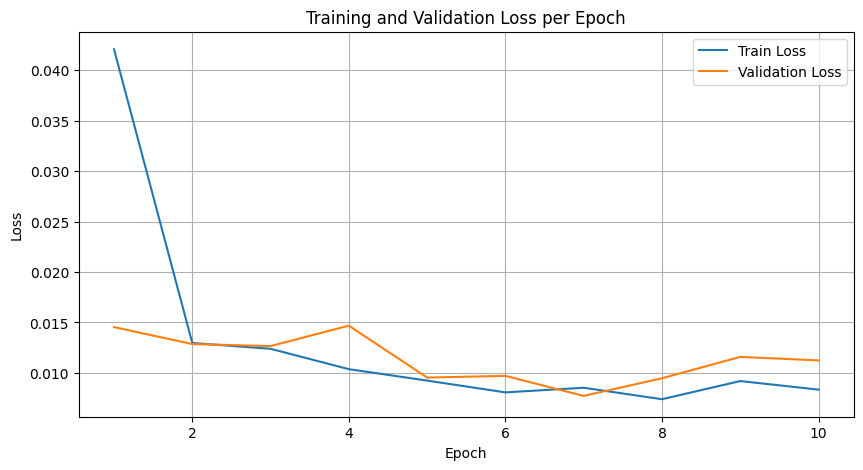

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualization
import matplotlib.pyplot as plt
train_losses = [entry['train_loss'] for entry in epochs_stats]
val_losses = [entry['val_loss'] for entry in epochs_stats]
epochs = [entry['epoch'] for entry in epochs_stats]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig( name_model + '.png', format='png', dpi=300, bbox_inches='tight', transparent=True)

